In [1]:
from lle import LLE, Action, WorldState
import marl
import marlenv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from marl.other.local_graph import LocalGraphTrainer, LocalGraphBottleneckFinder

In [4]:
map_name = "maps/subgraph-2agents.toml"
# map_name = "maps/subgraph-1agent.toml"
env = LLE.from_file(map_name).obs_type("layered").single_objective()
world = env.world
if env.n_agents == 1:
    mask = np.full((env.n_agents, env.n_actions), True)
    mask[:, Action.STAY.value] = False
    env = marlenv.Builder(env).mask_actions(mask).build()

qnetwork = marl.nn.model_bank.CNN.from_env(env)
policy = marl.policy.EpsilonGreedy.linear(1.0, 0.05, 100_000)
algo = marl.algo.DQN(qnetwork, policy)
dqn_trainer = marl.training.DQNTrainer(
    qnetwork,
    policy,
    marl.models.TransitionMemory(10_000),
    mixer=marl.algo.VDN.from_env(env),
    lr=1e-4,
    gamma=0.95,
    train_interval=(100, "step"),
)


finder = LocalGraphBottleneckFinder()
trainer = LocalGraphTrainer(finder, world, None)
exp = marl.Experiment.create(logdir="logs/test", trainer=trainer, n_steps=100_000, test_interval=0, env=env)
exp.run()

Training:   0%|          | 0/100000 [00:00<?, ?Step/s]

Time step 1000
Time step 2000
Time step 3000
Time step 4000
Time step 5000
Time step 6000
Time step 7000
Time step 8000


Training:   8%|▊         | 8113/100000 [00:21<04:07, 370.97Step/s]

Time step 9000
Time step 10000


Training:  11%|█         | 10724/100000 [00:24<03:07, 474.95Step/s]

Time step 11000
Time step 12000
Time step 13000
Time step 14000
Time step 15000
Time step 16000
Time step 17000
Time step 18000
Time step 19000
Time step 20000
Time step 21000
Time step 22000
Time step 23000
Time step 24000


Training:  24%|██▍       | 24168/100000 [00:26<00:58, 1291.64Step/s]

Time step 25000
Time step 26000
Time step 27000
Time step 28000


Training:  28%|██▊       | 28361/100000 [00:34<01:13, 973.89Step/s] 

Time step 29000
Time step 30000
Time step 31000
Time step 32000
Time step 33000
Time step 34000


Training:  34%|███▍      | 34142/100000 [00:40<01:09, 951.18Step/s]

Time step 35000


Training:  35%|███▌      | 35334/100000 [00:41<01:05, 982.40Step/s]

Time step 36000
Time step 37000
Time step 38000


Training:  39%|███▊      | 38502/100000 [00:42<00:52, 1165.79Step/s]

Time step 39000
Time step 40000
Time step 41000
Time step 42000


Training:  42%|████▏     | 42230/100000 [00:43<00:36, 1581.69Step/s]

Time step 43000
Time step 44000
Time step 45000
Time step 46000
Time step 47000
Time step 48000
Time step 49000
Time step 50000


Training:  50%|█████     | 50135/100000 [00:43<00:18, 2658.52Step/s]

Time step 51000
Time step 52000
Time step 53000
Time step 54000


Training:  55%|█████▍    | 54787/100000 [01:12<01:30, 501.76Step/s] 

Time step 55000
Time step 56000
Time step 57000
Time step 58000


Training:  59%|█████▊    | 58692/100000 [01:13<01:04, 642.99Step/s]

Time step 59000
Time step 60000
Time step 61000
Time step 62000
Time step 63000
Time step 64000
Time step 65000
Time step 66000
Time step 67000
Time step 68000
Time step 69000
Time step 70000
Time step 71000
Time step 72000
Time step 73000
Time step 74000
Time step 75000
Time step 76000
Time step 77000
Time step 78000
Time step 79000
Time step 80000
Time step 81000
Time step 82000
Time step 83000


Training:  84%|████████▎ | 83730/100000 [02:38<00:46, 352.05Step/s]

Time step 84000
Time step 85000
Time step 86000


Training:  87%|████████▋ | 86792/100000 [02:39<00:33, 389.99Step/s]

Time step 87000
Time step 88000
Time step 89000
Time step 90000
Time step 91000


Training:  92%|█████████▏| 91720/100000 [02:39<00:17, 483.38Step/s]

Time step 92000
Time step 93000
Time step 94000
Time step 95000


Training:  95%|█████████▌| 95269/100000 [02:41<00:08, 546.78Step/s]

Time step 96000
Time step 97000
Time step 98000
Time step 99000
Time step 100000


Training: 100%|██████████| 100000/100000 [02:48<00:00, 593.16Step/s]


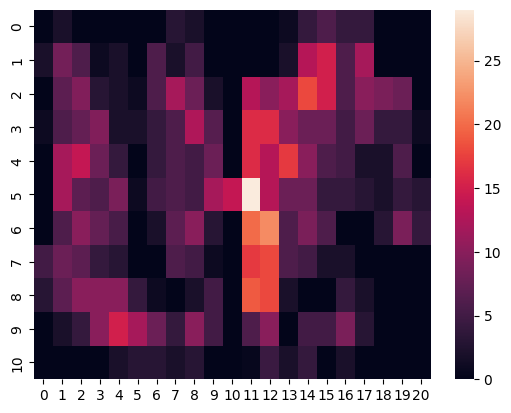

In [5]:
from collections import defaultdict

def get_bottlenecks_stats(finder: LocalGraphBottleneckFinder[WorldState]):
    """Project the edges on the 2D plane"""
    vertex_bottleneck_scores = defaultdict[tuple[int, int], float](int)
    edge_bottleneck_scores = defaultdict[tuple[WorldState, WorldState], float](int)
    for edge, hit_count in finder.hit_count.items():
        score = finder.predict(edge)
        edge_bottleneck_scores[edge] += score
        start, end = edge
        vertices = start.agents_positions + end.agents_positions
        for vertex in vertices:
            vertex_bottleneck_scores[vertex] += score
    return vertex_bottleneck_scores, edge_bottleneck_scores


def compute_heatmap(finder: LocalGraphBottleneckFinder[WorldState]):
    """Compute the heatmap of the bottlenecks"""
    vertex_scores, _ = get_bottlenecks_stats(finder)
    heatmap = np.zeros((world.height, world.width))
    for (i, j), score in vertex_scores.items():
        heatmap[i, j] = score
    return heatmap

scores_heatmap = np.zeros((world.height, world.width), dtype=np.float32)
scores_heatmap += compute_heatmap(finder)
sns.heatmap(scores_heatmap)
plt.show()
